# Netflix-Sentiment-Classification-Two

# Imports

In [15]:
import os

import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt


from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler, PowerTransformer

# Functions

In [11]:
def check_for_nulls_dupes(df):
  print(f"The amount of NaN values: {df.isna().sum()}")
  print(f"The amount of Duplicated values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()
  
def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  
  filtered_word_tokens = re.sub(f"[^a-zA-z\s]", "", word_tokens).split(" ")
  filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
  return " ".join(filtered_sentence).strip()

# EDA Analysis

In [2]:
df = pd.read_csv("/Users/maukanmir/Downloads/netflix_reviews.csv",nrows=10000)
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,1772b40f-8cfd-4c56-a370-c944e5b5ce48,Gato Reviews,Utter trash. Been a customer for over 10 years...,1,0,8.114.0 build 19 50680,2024-05-23 22:35:45,8.114.0 build 19 50680
1,b6b64d5c-30f6-4bed-8d66-9b4582e72e3b,Quincy Alleyne,Good,5,0,8.115.2 build 6 50688,2024-05-23 22:34:47,8.115.2 build 6 50688
2,8be7d06b-f90e-4ca7-abf6-f908b40946e2,nez zuber,The only streaming service that beats Netflix ...,2,0,NaN,2024-05-23 22:33:52,NaN
3,72485684-9e73-4dca-a580-0a92b3a3a7e6,Elon Frett,Everything that's objectively good gets remove...,1,0,8.109.0 build 7 50647,2024-05-23 22:30:43,8.109.0 build 7 50647
4,348796c3-0056-4491-80f7-d6c38fcb2790,kwakhanya bambeni,Wish the owner be a trillioner because he/she ...,4,0,NaN,2024-05-23 22:30:27,NaN
...,...,...,...,...,...,...,...,...
9995,260fc52a-ec27-468e-8029-7029391e2dcc,hafiz ejaz,I have used the previous version of the Netfli...,3,836,8.52.2 build 14 50335,2022-12-17 04:34:27,8.52.2 build 14 50335
9996,2ef0eca9-14bf-42f4-b2bb-3836e3ce29eb,Nikolas Mitchell,"I'm disappointed by this recent ""update"" it ma...",1,2,NaN,2023-05-10 11:29:41,NaN
9997,ed5e9c73-0448-4603-a551-8eef04b9730f,William Pearson,A great way to watch some shows and movies! An...,4,274,7.84.1 build 28 35243,2020-12-28 20:03:15,7.84.1 build 28 35243
9998,47441c89-bab5-42b3-b249-a7ce0b43598a,Sorsa,I have limited space on the internal storage o...,2,16,8.30.3 build 14 50239,2023-08-23 15:51:10,8.30.3 build 14 50239


# Check for Nulls and Dupes

In [4]:
check_for_nulls_dupes(df)

The amount of NaN values: reviewId                  0
userName                  0
content                   2
score                     0
thumbsUpCount             0
reviewCreatedVersion    971
at                        0
appVersion              971
dtype: int64
The amount of Duplicated values: 287


In [5]:
df.dropna(inplace=True)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.shape

(8802, 8)

# Check for Class Imabalance

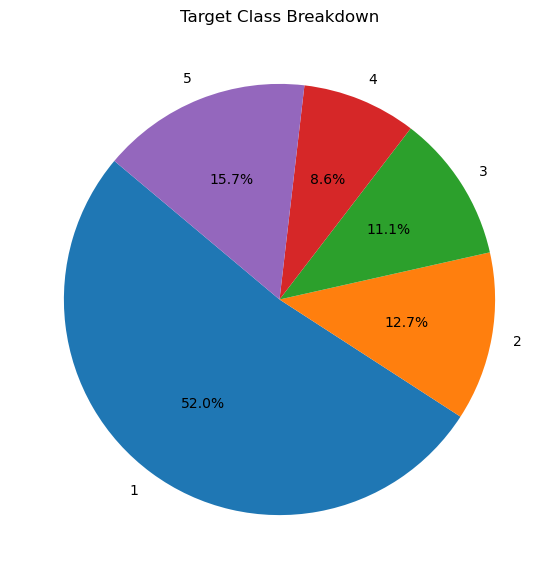

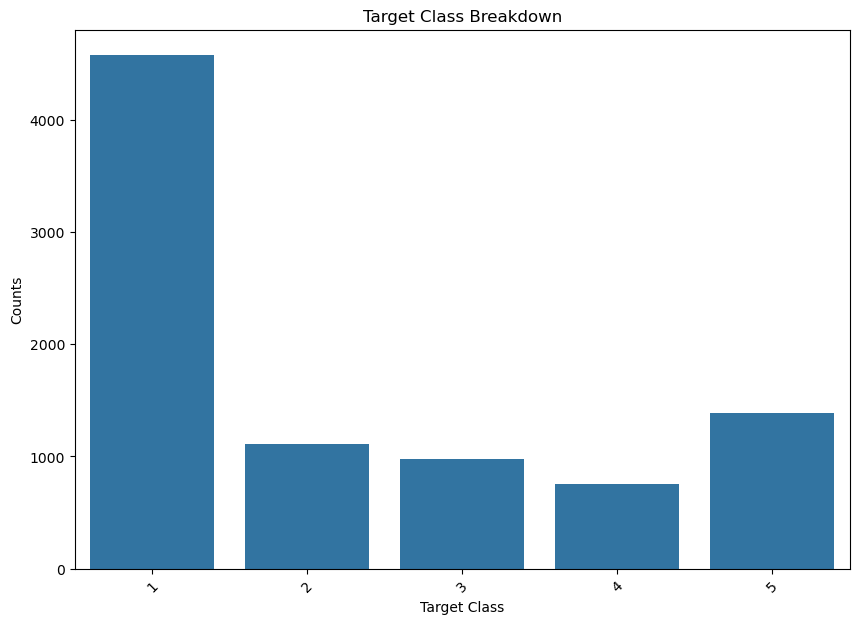

In [8]:
check_class_imbalance(df["score"])

# Skewed Dataset

# Drop Columns we do not need

In [9]:
df.drop(["reviewId", "userName", "reviewCreatedVersion", "appVersion"],axis=1, inplace=True)

# Data Preprocessing

In [12]:

df["content"] = df["content"].apply(lambda x: remove_stop_words(x))
df["score"] = df["score"].apply(lambda x: "postive" if x>=4 else "neg" if x<3 else "neu")
df["at"] = pd.to_datetime(df["at"])

df["day"] = df["at"].dt.day
df["month"] = df["at"].dt.month
df["year"] = df["at"].dt.year
df["hour"] = df["at"].dt.hour

df.drop("at", axis=1, inplace=True)

# Separate Feature Variables

In [13]:
X, y = df.drop("score", axis=1), df["score"]